In [55]:
%matplotlib inline 
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import timeit,time
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import math
from random import*
from numpy.testing import assert_almost_equal
import time

In [54]:
start = time.time()
end = time.time()
print(end-start)

4.5299530029296875e-05


In [2]:
def regression(A,b):
    regression_model = LinearRegression()
    regression_model.fit(A,b)
    return regression_model.coef_

In [3]:
def plots(x,y1,y2,y3,y5):
    plt.figure(figsize=(8,6),dpi=80)
    plt.scatter(x,y1,color="red",label='Leverage Score')
    plt.plot(x,y1,color="red",linewidth=2.0,linestyle="--")
    
    plt.scatter(x,y2,color="green",label='LandMark Selection')
    plt.plot(x,y2,color="green",linewidth=2.0,linestyle="--")
    
    plt.scatter(x,y3,color="orange",label='Kmeans++')
    plt.plot(x,y3,color="orange",linewidth=2.0,linestyle="--")

    plt.scatter(x,y5,color="brown",label='Scalable Kmeans||')
    plt.plot(x,y5,color="brown",linewidth=2.0,linestyle="--")
    plt.xlabel('---Sketched Matrix size--->')
    
    plt.ylabel('---Ratio(Approximation/Optimal)-->')
    plt.legend()
    plt.grid(b=True)
    plt.show()

In [4]:
def GA(n,d):
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    X = np.random.multivariate_normal(mean,C,(n)) # this is A
    beta = list()
    beta.extend(np.ones(5))
    beta.extend(0.1*np.ones(d-10))
    beta.extend(np.ones(5))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

In [79]:
def T3(n,d):
    df = 3
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y
    
    

In [78]:
def T1(n,d):
    df = 1
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

In [26]:
def LSS(A,b):
    l2norm=list() #for storing l2 norm across various size changes
    ratio = list()
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    leveragescore = np.sum(np.abs(u)**2,axis=1) # for rows the matrix considered is column :
    prob = leveragescore/sum(leveragescore)
    for k in s: # s represent the lsit of number of cluster
        r=0
        for i in range(10):
            index = np.random.choice(row,k,replace = True,p=prob)
            #print(index)
            #C = A[index,:] # selcting s rows
            C = A[index]
            A_sketch = C
            b_sketch = b[index]
            #regression call
            x_tilde = regression(A_sketch,b_sketch)
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    #print(ratio)
    return ratio

In [33]:
def LMS(A,b):
    l2norm = list()  # this is for sketched
    #ratio = list()
    aug_A = np.c_[A,b]
    for k in s:
        r=0
        for i in range(10):   
            k_cluster=KMeans(n_clusters=k,init='random',n_init=1,random_state=0).fit(aug_A)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1] # placing the first d columns in A sketch
            b_sketch = C[:,-1]  #placing the (d+1)th column in b
            x_tilde = regression(A_sketch,b_sketch)
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
        # only for sketched matrix
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio

In [34]:
def KPP(A,b):
    l2norm = list()
    #ratio = list()
    aug_A = np.c_[A,b]
    for k in s:
        r=0
        for i in range(10):
            k_cluster=KMeans(n_clusters=k,init='k-means++',n_init=1,random_state=0,max_iter=1).fit(aug_A)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1] # placing the first d columns in A sketch
            b_sketch = C[:,-1]#placing the (d+1)th column in b
            x_tilde = regression(A_sketch,b_sketch) 
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio

In [35]:
def SKPP():
    global l2Matrix
    global factor,s
    global C_dash,C_index,mcp
    
    C_dash.clear()
    C_index.clear()
    x=0
    y=0
    for f in factor:
        for k in s:
            l2norm_temp=0
            const = 10
            
            # --- running it multiple times to take the average 
            for i in range(const):
                
                C_dash.clear()
                C_index.clear()
                mcp = np.full((3,row),np.inf)
                
                wC = KmeansP(f*k)
                k_cluster=KMeans(n_clusters=k,init='k-means++',n_init=1,max_iter=1,random_state=0).fit(wC)
                C = k_cluster.cluster_centers_
                A_sketch = C[:,:-1]
                b_sketch = C[:,-1]
                x_tilde = regression(A_sketch,b_sketch)
                # for plotting purpose
                l2norm_temp += np.linalg.norm((A.dot(x_tilde))-b,ord=2)
            l2Matrix[x][y]=l2norm_temp/const
            y+=1
        x+=1
        y=0
    l2Matrix = l2Matrix/l2normOpt
    return l2Matrix[0][:]

In [36]:
def KmeansP(l): # augmented A is passed
    global C_index,C_dash,aug_A,row,mcp
    
    index= int(np.random.choice(row,1))
    C_index.add(index)
    C_dash.add(index)
    
    loop=5
    # Calculate probability of each point of x
    for i in range(loop):
    #-- computing the distance of each point to its nearest center 
        if(len(C_dash)>0):
            computeDist() #-- Calling distance
            phi = np.sum(mcp[0][:])  # summing up the first row corresponding to the distances
    
            mcp[2][:] = np.multiply(mcp[0][:],l)/phi # storing the squared distances of each point to nearest cluster
            u,c=np.unique(mcp[1][:], return_counts=True)
    
        #--- Sampling x independently from X with above computed probability
        for j in range(row):
            if(mcp[2][j]>np.random.random()):
                C_dash.add(j) # this is C'
        C_dash=C_dash.difference(C_index)
        C_index=C_index.union(C_dash)
    # loop ends
    
    # weight computation
    unique,counts = computeWeight()
    unique = [int(w) for w in unique]
    weighted_C = np.multiply(aug_A[unique],counts[:,np.newaxis])
    return weighted_C

In [37]:
def computeDist():
    global C_dash
    global mcp
    global aug_A
    global row
    for i in range(row):
        for c in C_dash:
            eucd_dist = np.square(np.linalg.norm(abs(aug_A[i]-aug_A[c]),ord=2))
            if(mcp[0][i] > eucd_dist or mcp[0][i]==np.inf):
                mcp[0][i]=eucd_dist
                mcp[1][i]=c

In [38]:
def computeWeight():
    global mcp
    unique,counts = np.unique(mcp[1][:], return_counts=True)
    #print(unique.shape,counts.shape)
    return unique.tolist(), counts

In [86]:
n= int(input("Number of rows: "))
d=int(input("Number of columns >20: "))
row = n
s = [row/25,row/32,row/40,row/50,row/64]
s = [round(x) for x in s]
factor=[1]

#mcp = np.full((3,row),np.inf)
C_index = set([]) # for storing index of cluster chosen from A
C_dash = set([])
# mindist_cluster_probability = mcp
# mindist 1st row: for storing min dist
# mindist 2 row: to which cluster
# mindist 3rd row: prob

Number of rows:  7800
Number of columns >20:  35


In [42]:
def execute(A,b):
    r1,r2,r3,r5= controller2(A,b)
    plots(s,r1,r2,r3,r5)

In [43]:
def controller2(A,b):
    r1 = LSS(A,b)
    r2 = LMS(A,b)
    r3 = KPP(A,b)
    r5 = SKPP()
    return r1,r2,r3,r5

In [59]:
A,b=GA(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
l2Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
row,col = aug_A.shape
#mcp = np.full((3,row),np.inf)
#execute(A,b)
#n=1000 x 21

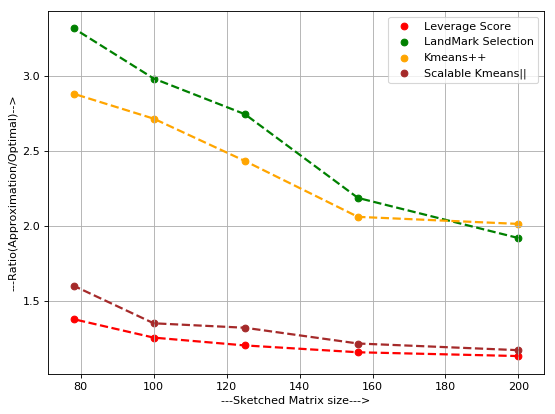

2672.6914200782776


In [60]:
#19/10/2018 run -1 GA
start = time.time()
mcp = np.full((3,row),np.inf)
execute(A,b)
end = time.time()
print(end-start)
# n= 5000 x 35 :
#f=1

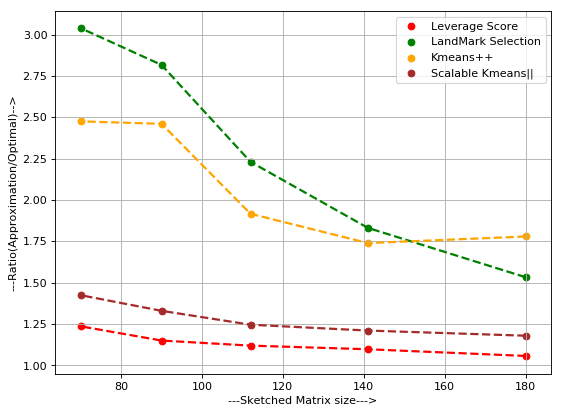

TypeError: unsupported operand type(s) for -: 'module' and 'module'

In [46]:
# date 17/10 GA run-2
start = timeit.time
mcp = np.full((3,row),np.inf)
execute(A,b)
end = timeit.time
print(end-start)
# n= 4500 x 22 :
# f =2

In [63]:
# GA 5000x35 running time in sec (19/10)
print((end-start)/60)

44.54485700130463


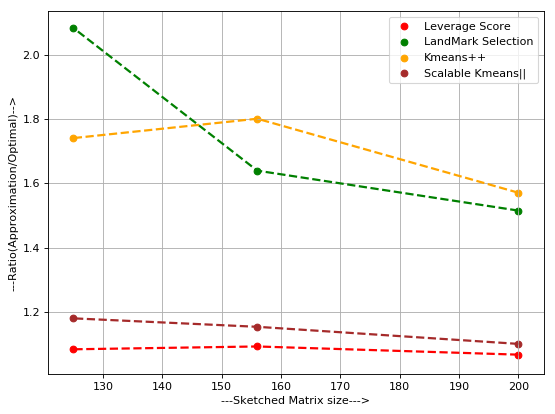

In [54]:
#faulty
mcp = np.full((3,row),np.inf)
execute(A,b)
#n=5000 x 21 GA

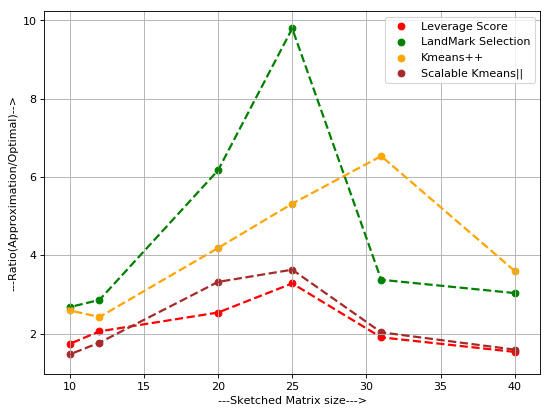

In [80]:
#faulty
mcp = np.full((3,row),np.inf)
execute(A,b)
#n=5000 x 21 GA : len of s in increaed

In [65]:
A,b = T3(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
l2Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
row,col = aug_A.shape
#mcp = np.full((3,row),np.inf)
#execute(A,b)
# n = 1000 x 21 T3

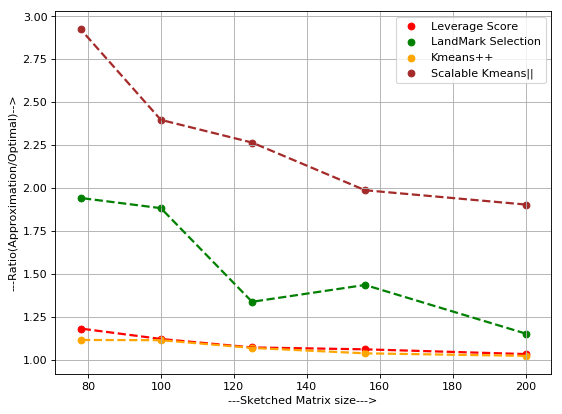

43.201826854546866


In [66]:
# 19/10/2018 run 1 T3
start= time.time()
mcp = np.full((3,row),np.inf)
execute(A,b)
end=time.time()
print((end-start)/60)
# n = 5000 x 35
#f = 1

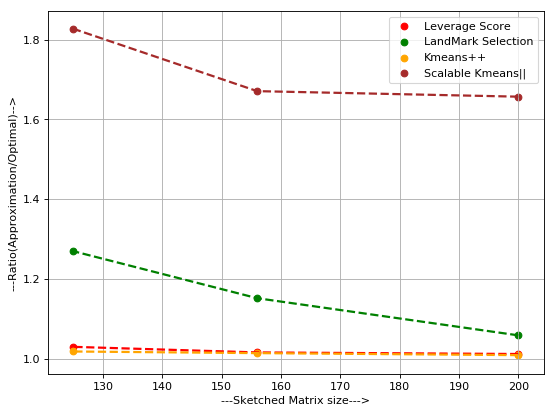

In [56]:
#older
mcp = np.full((3,row),np.inf)
#execute(A,b)
# n = 5000 x 21 T3

In [68]:
print(n,d)

5000 35


In [88]:
A,b=T1(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
l2Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
#row,col = aug_A.shape
#mcp = np.full((3,row),np.inf)
#execute(A,b)

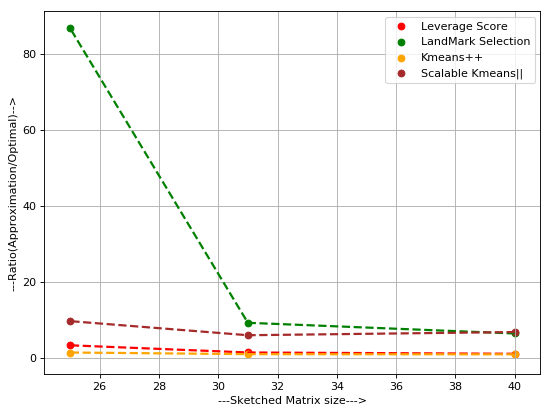

In [38]:
#older
mcp = np.full((3,row),np.inf)
execute(A,b)

In [83]:
print(A.shape)

(7800, 25)


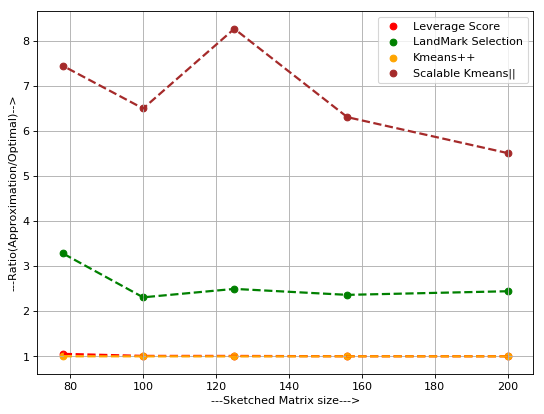

30.3002091050148


In [74]:
#19-10-2018 run-1-T1
start = time.time()
mcp = np.full((3,row),np.inf)
execute(A,b)
end=time.time()
print ((end-start)/60)

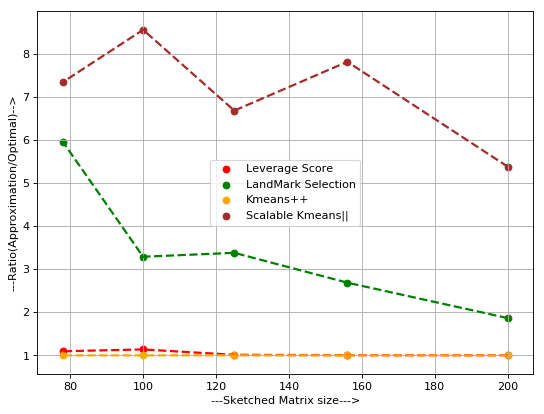

26.93681735197703


In [77]:
#19-10-2018 run-2-T1
start = time.time()
mcp = np.full((3,row),np.inf)
execute(A,b)
end=time.time()
print ((end-start)/60)
# n 5000
#d - 35
# f - 1

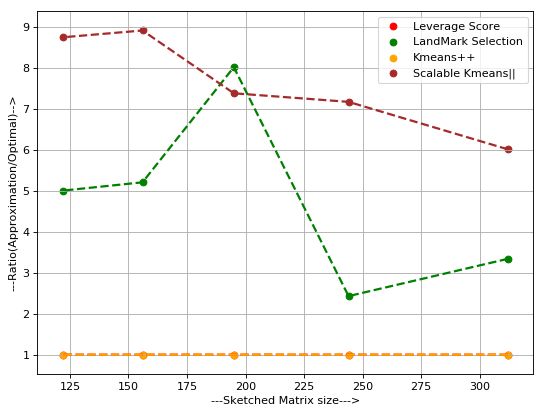

54.24582231044769


In [85]:
# nxd 7800x25
# f 1
#19-10-2018 run-1 T1
start = time.time()
mcp = np.full((3,row),np.inf)
execute(A,b)
end=time.time()
print ((end-start)/60)

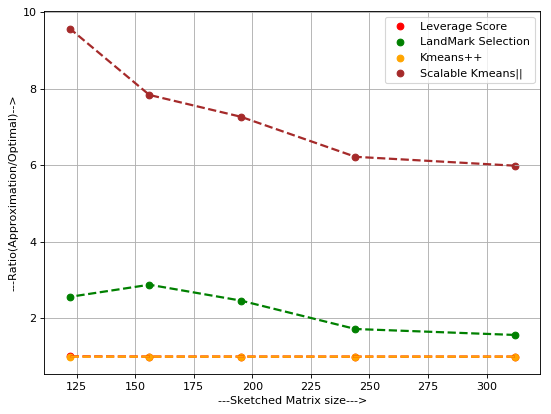

71.64126167297363


In [89]:
# nxd 7800x35 - rum 22/10/2018- run3 T1
# f 1
start = time.time()
mcp = np.full((3,row),np.inf)
execute(A,b)
end=time.time()
print ((end-start)/60)

## 10%

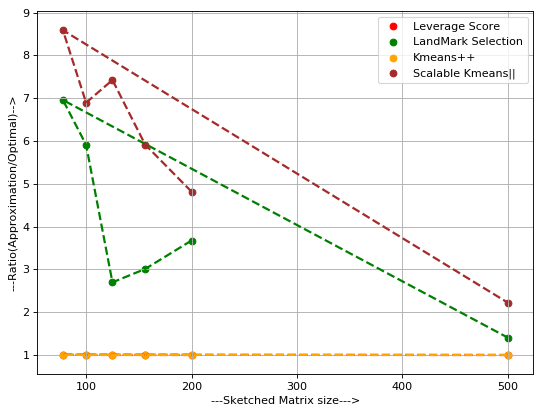

In [38]:
A,b=T1(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
l2Matrix = np.zeros((len(factor),len(s)))
aug_A = np.c_[A,b]
row,col = aug_A.shape
mcp = np.full((3,row),np.inf)
execute(A,b)